# Analyzing UMD Professor Salary and Review
### By Sean Huang and Tochukwu Ibe-Ekeocha


## Introduction

In this project, we want to analyze two main datasets about the professors in the University of Maryland. The first is data about the salaries of all the professors at the University of Maryland. The second is the student-created reviews of classes taught by the professors. Our goal it to use a number of tools and methodologies from the data science pipeline to use the datasets to make meaningful insights about the relationship between professor salary and student course review.

In [1]:
import requests as req
import pandas as pd
import sqlite3 as sql
import requests
from functools import reduce
import numpy as np
import os.path
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Data  Collection

To start, we first need some data on both the salaries of each professor in the university as well as their reviews. For the salary data, we were able to get a SQL database from a website called the Diamondback Salary Guide(https://salaryguide.dbknews.com/), a platform that allows the user to look up any university staff and get their salary, department, and position. The local file salaries_data.sql stores the firstname, lastname, department, salary, and position of each professors.

In [2]:
db = sql.connect(":memory:")
sqlite_file = 'salaries_data.sql'
sql_file = open(sqlite_file)
sql_as_string = sql_file. read()
db. executescript(sql_as_string)

Using a SQL query, we were able to extract each of the professor's information into a DataFrame object.

In [3]:
salary_query= """
SELECT 
 firstname, lastname, department, salary, position
FROM Salaries
"""

salaries = pd.read_sql(salary_query, db)

salaries.head()

,firstname,lastname,department,salary,position
0,DJ,Durkin,PRES,881010.96,Head Coach
1,Darryll J,Pines,PRES,765000.00,President
2,Wallace,Loh,PRES,734565.88,Spec Asst to the Pres
3,Mark,Turgeon,PRES,723312.99,Head Coach
4,Brenda S,Frese,PRES,659386.43,Head Coach BB


For the review data, we used PlanetTerp, the official review site for UMD professors. We wrote a helper method that will help us read in the data later. Using PlanetTerp's API(https://api.planetterp.com/#planetterp-api), we pull the data for all of the professors, 1000 professors at a time. We wrote a function to read in all of the professor's information and returns them. This API gives us the information of all the professors's name, slug("the professor's unique id in PlanetTerp, all the different courses they taught, and their reviews.

In [4]:
def fetch_profs(): 
    profs = dict()
    for i in range(0, 10000, 1000):
        r = requests.get('https://api.planetterp.com/v1/professors?reviews=true', params={
          'limit': '1000',
          'offset': i,
        }, headers = {'Accept': 'application/json'})

        for e in r.json():
            # using the slug, which is the unique identifier which PlanetTerp uses for each professor
            profs[e.get("slug")] = e 
    return profs

We also wrote a function that gives us the all the reviews on PlanetTerp. Given a list of PlanetTerp names and ids for each professor from the DataFrame we return a DataFrame that contains the slug, rating, expected_grade, course, and review for all of the reviews for that professor. Since the process of pulling every single professor from PlanetTerp takes a long time, we decided to check if there is a local database we can use before calling the API, and just using the local data if one is found. If one is not found, we fetch the data normally and make sure to save the dataset in a csv file so we can use it next time.

In [5]:
def fetch_reviewsData(names, ids):
    if(path.isfile("reviews.csv")):
        return pd.read_csv("reviews.csv")
        
    reviews_data = []
    i = 0
    for v in names:

        r = requests.get('https://api.planetterp.com/v1/professor', params={
          'name': v,  'reviews': 'true'
        }, headers = {'Accept': 'application/json'}).json()


        slug = r.get("slug")
        revs = r.get("reviews")
        if(revs == None):
            continue

        for rev in revs:  

            reviews_data.append([ 
                slug,
                rev.get("rating"),  
                rev.get("expected_grade"), 
                rev.get("course"),
                rev.get("review"),
                ids[i]
            ])
            
        i += 1;
    reviews_df = pd.DataFrame(reviews_data, columns=['slug', 'rating', 'expected_grade', 'course', 'review', "prof_df_id"])
    reviews_df.to_csv(path_or_buf="reviews.csv", index=False)
    return  reviews_df

## Data management

Next, we're going to use all the functions above to get the intersections between our salaries dataset and the professors of PlanetTerp. To help us match a professor in the salary data to a professor in PlanetTerp's data, we wrote a helper function that takes a professor's information and finds a match for the professor in the salary SQL database. We match a professor if they have a similiar lastname(determined by the LIKE operator in our SQL query) and the same department.

In [6]:
def fetch_matches_for_dept(dep, profs):
    matches = dict()

    for prof in profs.values():
        
        slug = prof.get("slug")
        name = prof.get("name")
        courses = prof.get("courses")
        reviews = prof.get("reviews")

        lastname = name.split(" ")[-1] 

        # using lastname and department as a way to narrow down the searches
        salary_query= f"""
            SELECT 
            firstname, 
            lastname,
            department,
            salary,
            position
            FROM Salaries
            WHERE lastname like "{lastname}"
            AND department = "{dep}"
        """
        rows = list(db.execute(salary_query))
        matches[lastname] = (len(rows), rows, name, slug, courses, reviews)
        
    return matches

Next, we're going to use all the functions above to get the combined data of our salaries dataset and the professors dataset of PlanetTerp. We first use the fetch_profs() function to get a list of all of the professor's information on PlanetTerp. We then match each individual professors to their salary information using fetch_matches_for_dept(). We calculate their average rating with our calc_avg_rating function, that goes through all of their reviews and find the average of all of the rating they got. We also check the amount of different courses a professor has taught by parsing the string with all of their courses and store it under the num_courses column.

Again, since the process of geting all the professors from PlanetTerp and matching them takes a long time, we check for whether there is local dataset that we can use and use that if one is found. If one is not found, fetch and match the professors normally and save our data as a csv file so we can use that next time.

In [7]:
# given a list of reviews, calculate the average rating
def calc_avg_rating(revs):
    length = len(revs)
    if(length == 0):
        return np.nan
    total = 0
    for r in revs:
        total += r.get("rating")
    return total / length


matched_salaries = None # variable for the first dataframe

if(path.isfile("matched_salaries.csv")):
    matched_salaries = pd.read_csv("matched_salaries.csv")
else: 
    
    profs = fetch_profs() # dictionary of all the profesors
    matched_profs = dict() # used to match the profesors

    arr = list(set(salaries["department"]))
    
    for dep in arr:  
        matches = fetch_matches_for_dept(dep, profs)
        for match in matches.keys():
            (length, v, name, slug, courses, reviews) = matches.get(match)
            if(length > 0):
                
                # use firstname to further narrow down the search
                firstname = name.split(" ")[0]
                ret = [m for m in v if m[0].find(firstname) >= 0]
                
                if(len(ret) > 0):
                    value = ret[0]
                    matched_profs[slug] = (
                        value[0],
                        value[1],
                        value[2],
                        value[3],
                        value[4],
                        calc_avg_rating(reviews),
                        slug,
                        name,
                        "-".join(courses),
                        len(courses)
                    )

    matched_salaries = pd.DataFrame(matched_profs.values(), columns=['firstname', 'lastname', 'department', 'salary', "position", "avg_rating", 'slug', "planetTerpName", "courses", "num_courses"])
    matched_salaries.to_csv(path_or_buf="matched_salaries.csv", index=False)

matched_salaries.head()

,firstname,lastname,department,salary,position,avg_rating,slug,planetTerpName,courses,num_courses
0,Blessing,Enekwe,GRAD,82583.74,Coordinator,NaN,enekwe,Blessing Enekwe,BSOS388D,1
1,Scott P,Roberts,GRAD,168300.00,Asst Dean,4.533333,roberts_scott,Scott Roberts,PSYC424-PSYC798B-PSYC100-PSYC289E-PSYC111-UNIV...,10
2,Linda C,Macri,GRAD,94794.31,Director,NaN,macri,Linda Macri,ENGL101-ENGL388V-ENGL611-ENST702-ENGL321-TLTC699A,6
3,Steve,Fetter,GRAD,314016.39,Associate Provost & Dean,NaN,fetter,Steve Fetter,PUAF610,1
4,Diana S,Forbus,VPUR,59825.69,Program Manager,NaN,forbus,Diana Forbus,UNIV100-IDEA101,2


This first DataFrame contains all of the information about the professors from PlanetTerp (unique id, name, average rating) as well as their salary. Since we are only looking into professors, we filter the database to only inclue those with either "Lecturer" or "Professor" in their position. 

In [8]:
matched_salaries = matched_salaries[matched_salaries['position'].str.contains("Professor") | matched_salaries['position'].str.contains("Lecturer")]
matched_salaries.head()

,firstname,lastname,department,salary,position,avg_rating,slug,planetTerpName,courses,num_courses
8,Abbie Jan,Basile,INFO,10302.00,Lecturer,NaN,basile,Abbie Basile,LBSC602-LBSC713-INST201-INST702-LBSC702-LBSC641,6
9,Abdirisak Abdullahi,Mohamed,INFO,10302.00,Lecturer,NaN,mohamed,Abdirisak Mohamed,INST354-HLTH672-HLTH710-INST314-INST414-DATA606,6
10,Matthew Thomas,Miller,ARHU,76141.79,Assistant Professor,NaN,miller_thomas,Thomas Miller,MEES631-MEES608F-GEMS296-GEMS297-GEMS396-GEMS3...,11
11,Alex,Leitch,INFO,82416.00,Lecturer,2.5,leitch,Alex Leitch,INST377-INST639C-INST711-INST208M-INST228,5
12,Ana,Ndumu,INFO,108232.81,Assistant Professor,NaN,ndumu,Ana Ndumu,HLTH672-HLTH710-INST610-LBSC706-INST878A-LBSC6...,7


We then use our fetch_reviewsData() method written above to find all the associated reviews for only the professors we matched. This second DataFrame contains all the reviews, which contain the name of the professor, the class, the rating, the review itself, and the expected grade.

In [9]:
reviews_df = fetch_reviewsData(list(matched_salaries["planetTerpName"]), matched_salaries.index.values)
reviews_df.head()

,slug,rating,expected_grade,course,review,prof_df_id
0,leitch,1,NaN,INST377,Professor is so rude and sarcastic. She is ver...,11
1,leitch,3,A,NaN,Constantly threatens to report students to the...,11
2,leitch,5,A+,INST377,Professor Alex is a great at handling the tea...,11
3,leitch,1,NaN,INST377,This course was very disorganized. The workloa...,11
4,doran,5,A,INST311,I've learned a lot through his online class. H...,20


## Exploratory data analysis

In this section, we will start to take a look at the dataset and try to find patterns and correlations that could be relevant and used to form our hypotheses later. To start, we take a look at how a professor's review correlates with the professor's salary.

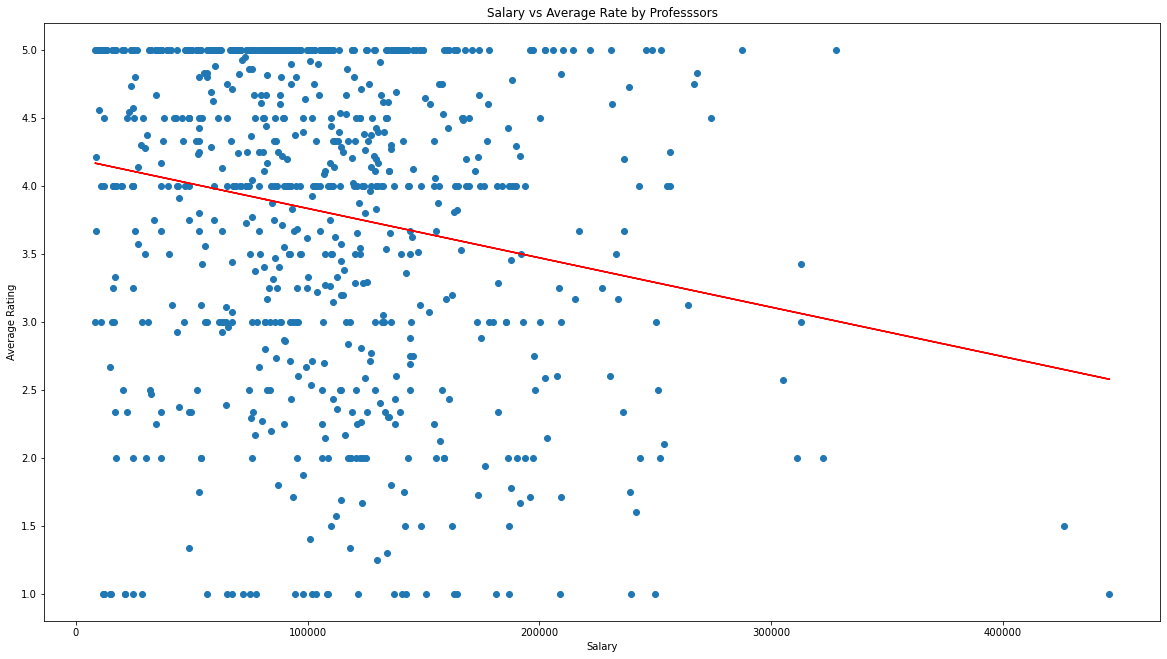

In [10]:
figsize = (20, 11)
prof_salary = matched_salaries.dropna(subset = ['avg_rating'])
prof_salary = prof_salary[prof_salary['position'].str.contains("Professor") | prof_salary['position'].str.contains("Lecturer")]

plt.figure(figsize=figsize)
plt.scatter(prof_salary['salary'], prof_salary['avg_rating'])
plt.xlabel('Salary')
plt.ylabel('Average Rating')

# Also adding a Linear Regression line
m,b = np.polyfit(prof_salary['salary'], prof_salary['avg_rating'], 1)
plt.plot(prof_salary['salary'], m * prof_salary['salary'] + b, color = 'red')
plt.title("Salary vs Average Rate by Professsors")
plt.show()

From this graph, we are able to see that there is a negative correlation between a professor's salary and the average review the professor has. This indicates that professors that are paid more are more likely to have a lower average review on PlanetTerp. 

We also wanted to see if there is a big difference between the average salary of professors in each department. So, we grouped the professor's salary data by department and found the average salary of each department's professors. We also sorted them to see the top salaries. 

In [11]:
dept_avg = matched_salaries.groupby("department").mean().sort_values(by=["salary"], ascending=False)
dept_avg = dept_avg.dropna()
dept_avg

,salary,avg_rating,num_courses
department,,,
BMGT,167145.402804,3.528004,8.065421
BSOS,123186.107529,3.924544,7.459770
SVPAAP,119150.247500,5.000000,4.750000
CMNS,119015.028953,3.571583,8.158915
ENGR,109848.009439,3.477048,6.850467
AGNR,103332.418000,3.990808,6.144444
EDUC,91367.317222,4.190476,8.422222
SPHL,84878.143971,4.036859,7.941176
PLCY,80498.639800,3.929924,5.180000


According to the DataFrame, we can see the top department for average salary being the Business School, the School of Behavioral and Social Science, and the Academy of Innovation & Entrepreneurship. The three schools that get paid the least are the school of Archeology, the Office of Undergraduate Studies, and the school of Environmental Science.

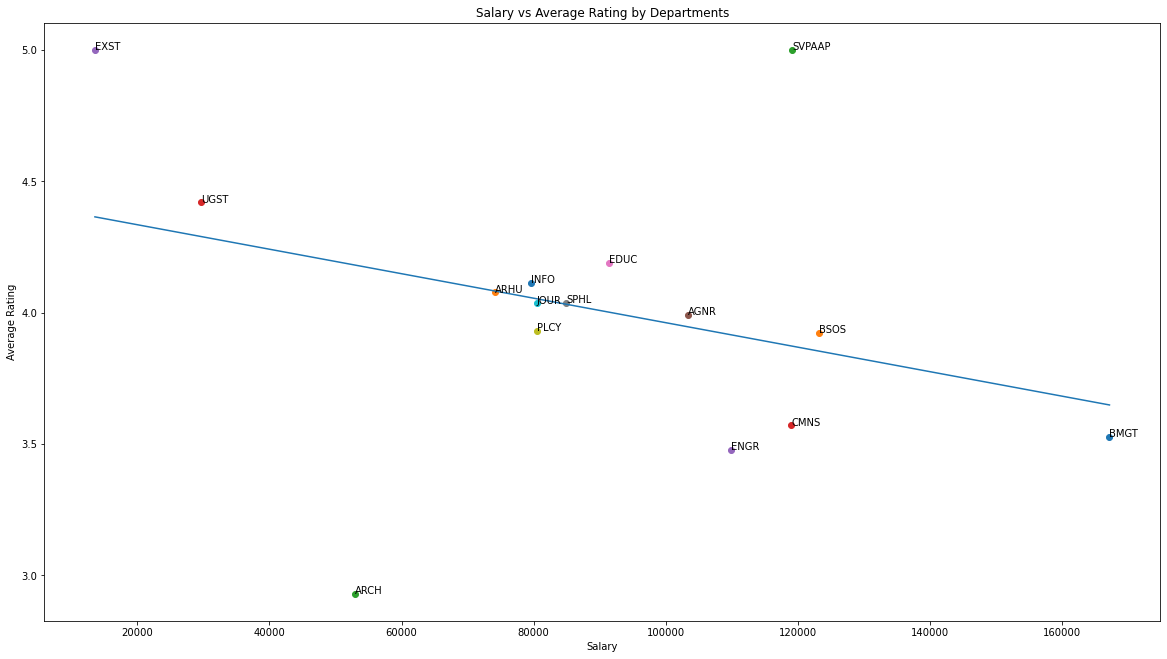

In [12]:
plt.figure(figsize=figsize)

# Adding annotations for each point
for i in dept_avg.index:
    plt.scatter(dept_avg.loc[i]['salary'], dept_avg.loc[i]['avg_rating'])
    plt.annotate(i, (dept_avg.loc[i]['salary'], dept_avg.loc[i]['avg_rating']))
    
plt.title('Salary vs Average Rating by Departments')
plt.xlabel('Salary')
plt.ylabel('Average Rating')

m,b = np.polyfit(dept_avg['salary'], dept_avg['avg_rating'], 1)


plt.plot(dept_avg['salary'], m * dept_avg['salary'] + b)

plt.show()

Just like above, we see the same negative correlation between salary and average rating. However, this graph also brings us information about departments that are outliers. For example, the school of Archeology gets a particularly low rating for its average salary and the school of Academy of Innovation & Entrepreneurship gets a high rating for its salary.

We also wanted to see if the amount of unique courses a professor has taught also correlates with the amount of salary that the professor earned. So, we created another scatterplot to check it.

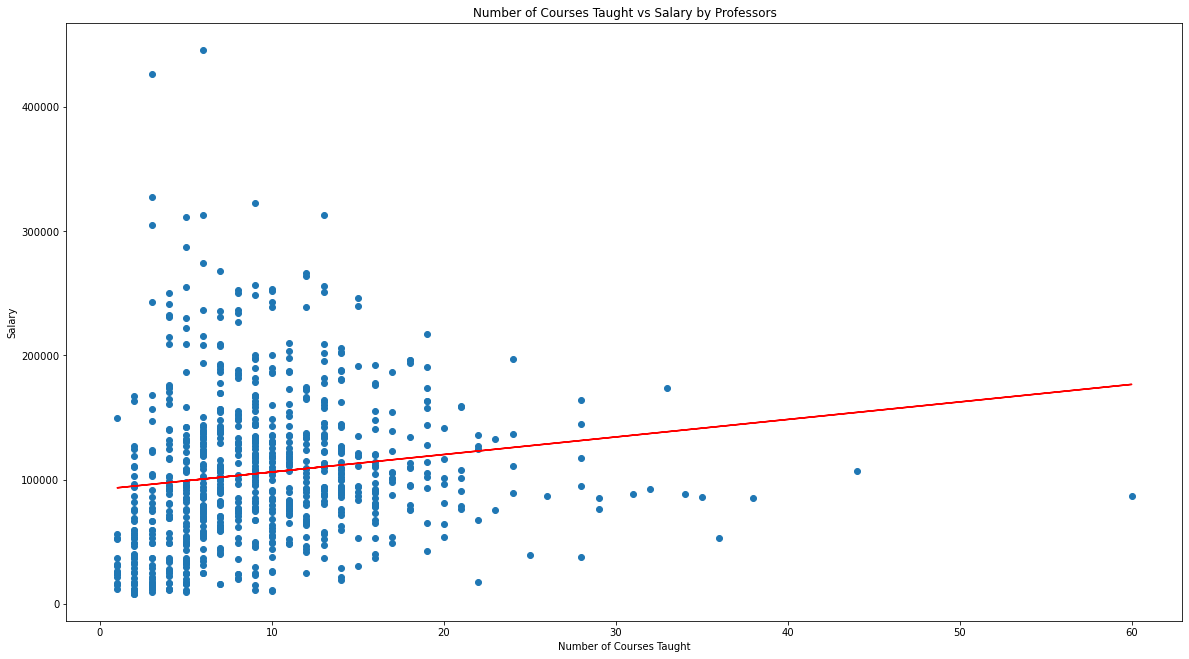

In [13]:
prof_salary = matched_salaries.dropna(subset = ['avg_rating'])
plt.figure(figsize=figsize)

plt.scatter(prof_salary['num_courses'], prof_salary['salary'])
plt.xlabel('Number of Courses Taught')
plt.ylabel('Salary')
plt.title('Number of Courses Taught vs Salary by Professors')

m,b = np.polyfit(prof_salary['num_courses'], prof_salary['salary'], 1)
plt.plot(prof_salary['num_courses'], m * prof_salary['num_courses'] + b, color = 'red')
plt.show()

The graph does show a positive correlation between the two, indicating that a professor that has taught many different courses is more likely to have a higher salary.

### Finding general correlation

To get a better look at what correlation exists in the dataset, we use a correlation matrix to match each column with all the other columns

[Text(0, 0.5, 'salary'),
 Text(0, 1.5, 'avg_rating'),
 Text(0, 2.5, 'num_courses')]

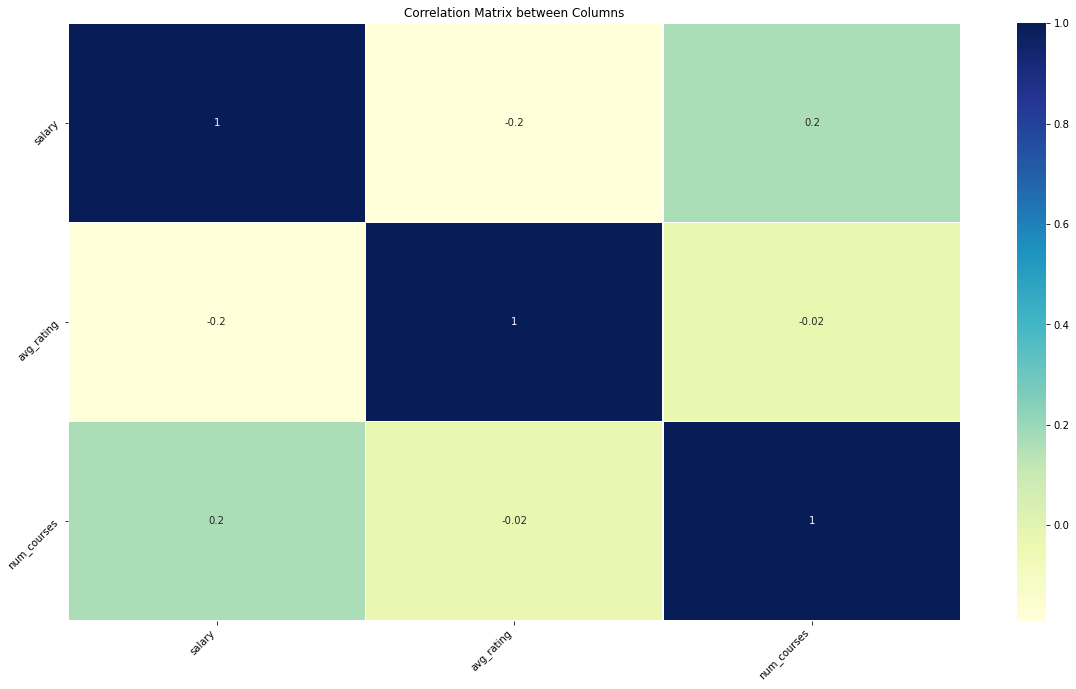

In [14]:
plt.subplots(figsize = figsize)
# using seaborn heat map to highlight the significant correlations
g = sns.heatmap(matched_salaries.corr(), annot = True, cmap = "YlGnBu", fmt = '.1g', linewidths=.5,)

g.set_title("Correlation Matrix between Columns")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')

There doesn't seem to be any significant correlation with any of the numerical data so far. We decided to include the department data to find any correlations for it.

Since the departments are categorical data, we decide to use the get_dummies function from pandas to convert it to numerical data. The new DataFrame includes a new column for each of the categories in the department column and indicates which category it belongs to with a 1 in the department a row belongs to and 0s in all other columns.

In [15]:
dept_features = pd.get_dummies(matched_salaries['department'], drop_first = True, prefix = 'dept')
std_features = matched_salaries[['avg_rating', 'salary', 'num_courses']]

#combine our data
comb_features = pd.concat([std_features, dept_features], axis = 1)

With the new dummies, we take a look at our updated matrix.

[]

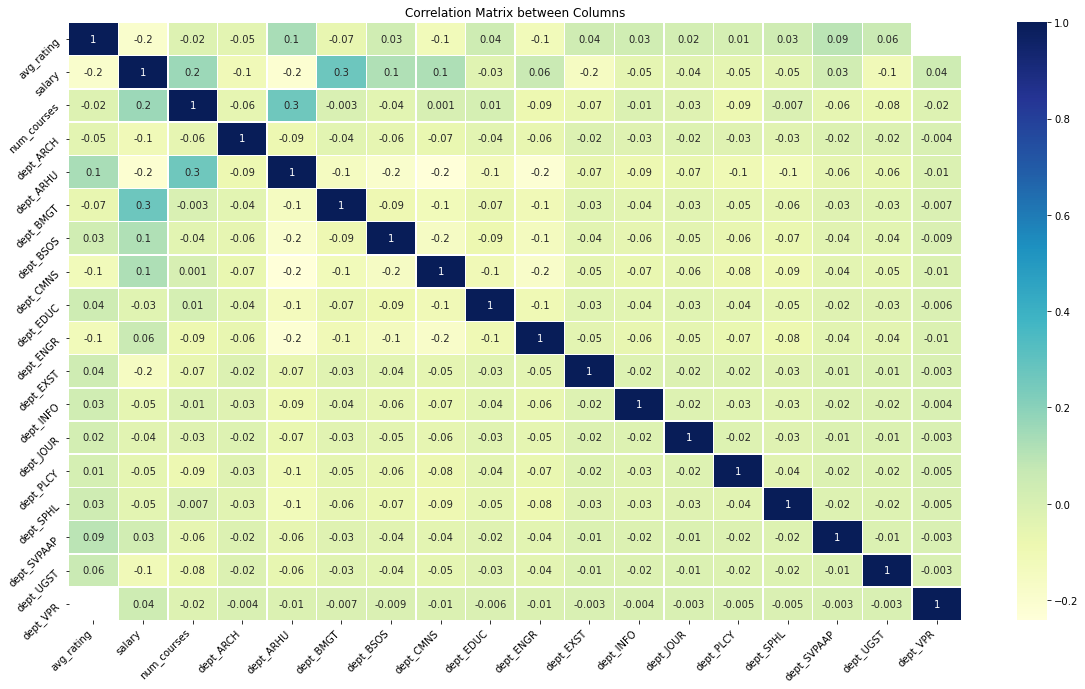

In [16]:
plt.subplots(figsize = figsize)
g = sns.heatmap(comb_features.corr(), annot = True, cmap = "YlGnBu", fmt = '.1g', linewidths=.5,)

g.set_title("Correlation Matrix between Columns")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')
g.plot()

Unfortunately, there is still no significant correlation between our data. The two strongest correlations are there are dept_BMGT with salary and dept_ARHU with num_courses. This indicates that a professor in BMGT is more likely to get a higher salary and a professor in ARHU is more likely to teach many different classes.

## Machine Learning

### MODEL 1

We first try to use a linear regression model to predict a professor's salary. Knowing the number of unique courses taught, average rating, and department for each of the professors, we can predict what their salary should be.

In order to add more context to the data, we need a way to represent relationships between columns in our DataFrame. We use the new DataFrame we got above to create two interaction terms(https://statisticsbyjim.com/regression/interaction-effects/) by multiplying the department column by the number of courses as well as the rating.

In [17]:
comb_features = comb_features.dropna()
for i in filter(lambda i : i!= 'AGNR', matched_salaries['department'].unique()):
    # create interaction terms by multiplying
    comb_features['num_course*' + i] = comb_features['dept_' + i]*comb_features['num_courses']
    comb_features['rating*' + i] = comb_features['dept_' + i]*comb_features['avg_rating']
    
comb_features

,avg_rating,salary,num_courses,dept_ARCH,dept_ARHU,dept_BMGT,dept_BSOS,dept_CMNS,dept_EDUC,dept_ENGR,...,num_course*UGST,rating*UGST,num_course*VPR,rating*VPR,num_course*SVPAAP,rating*SVPAAP,num_course*SPHL,rating*SPHL,num_course*ARCH,rating*ARCH
11,2.500000,82416.00,5,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0
20,5.000000,20604.00,8,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0
23,5.000000,107686.23,9,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0
25,5.000000,84991.50,9,0,0,0,0,0,1,0,...,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0
26,4.166667,82668.23,7,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,4.333333,103409.50,10,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,10,4.333333,0,0.0
2109,5.000000,105317.82,12,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,12,5.000000,0,0.0
2110,4.000000,86860.04,13,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,13,4.000000,0,0.0
2112,1.000000,97896.58,5,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,5,1.000000,0,0.0


We fit our data on a linear regression model, where X is the training data, which includes all the columns in the DataFrame except salary(avg_rating, department, and num_courses), and Y the target values, which is the salary.

In [18]:
#seperate our data
X = comb_features.drop('salary', axis = 1)
y = comb_features['salary']
reg = LinearRegression()
reg.fit(X,y)


LinearRegression()

After training the model, we used it to make predictions on every professor that has the independent variables in our DataFrame.

In [19]:
predictions = []
for i, row in matched_salaries.iterrows():
    if i in comb_features.index:
        # we make predications on the professors with all the available independent variables
        predictions.append(round(reg.predict([X.loc[i]])[0],2))
        
    else :
        predictions.append(np.nan)

# appending the predictions to the full set of professors
matched_salaries['predicted_salary'] = predictions
matched_salaries.head()

,firstname,lastname,department,salary,position,avg_rating,slug,planetTerpName,courses,num_courses,predicted_salary
8,Abbie Jan,Basile,INFO,10302.00,Lecturer,NaN,basile,Abbie Basile,LBSC602-LBSC713-INST201-INST702-LBSC702-LBSC641,6,NaN
9,Abdirisak Abdullahi,Mohamed,INFO,10302.00,Lecturer,NaN,mohamed,Abdirisak Mohamed,INST354-HLTH672-HLTH710-INST314-INST414-DATA606,6,NaN
10,Matthew Thomas,Miller,ARHU,76141.79,Assistant Professor,NaN,miller_thomas,Thomas Miller,MEES631-MEES608F-GEMS296-GEMS297-GEMS396-GEMS3...,11,NaN
11,Alex,Leitch,INFO,82416.00,Lecturer,2.5,leitch,Alex Leitch,INST377-INST639C-INST711-INST208M-INST228,5,79345.2
12,Ana,Ndumu,INFO,108232.81,Assistant Professor,NaN,ndumu,Ana Ndumu,HLTH672-HLTH710-INST610-LBSC706-INST878A-LBSC6...,7,NaN


To see how accurate our model is, we make a scatter plot of the predicted salary of each professor vs the actual salary of each professor.

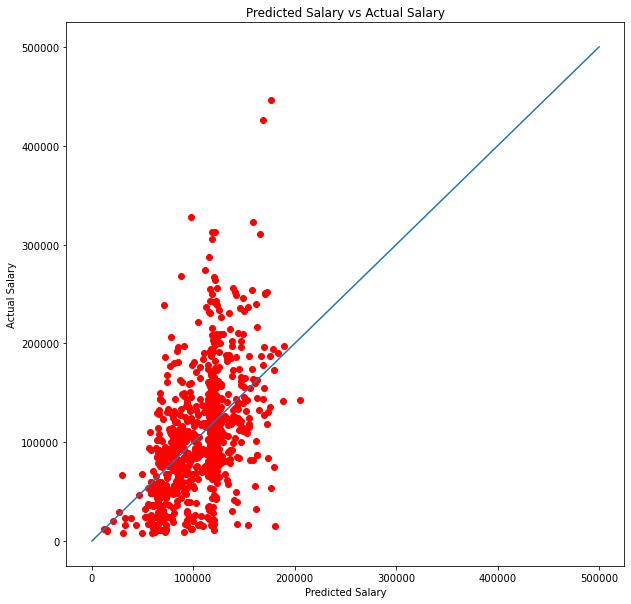

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(matched_salaries['predicted_salary'], matched_salaries['salary'], color="red")

plt.xlabel('Predicted Salary')
plt.ylabel('Actual Salary')
plt.title('Predicted Salary vs Actual Salary')

x = prof_salary['avg_rating']
y = prof_salary['salary']

# Added a line to indicate the perfect model
plt.plot([0,500000],[0,500000]) 

plt.show()

From the graph, we see that our predictions do follow the same trend as the actual salaries of the professor, especially with professors with lower income. However, there are a few notable cases of under-prediction outliers when it comes to professors with a very high income.

### MODEL 2

Next, we want to use salary, average rating, and department for each student's review to get a lot to predict the grades they got for that class. 

In [21]:
def get_salary(x): 
    return matched_salaries.loc[x.prof_df_id]["salary"]
def get_department(x):
    return matched_salaries.loc[x.prof_df_id]["department"]
    
# Converts letter grades into numberical values
def map_grades(g): 
    if(pd.isnull(g)):
        return np.nan
    
    # determined cutoffs
    d = {'A': 90, "B": 80, "C": 70, "D": 60, "F": 50} 
    
    # using regex to extract the letter grade
    match = re.search('[a-z|A-Z]', g, re.IGNORECASE) 
    
    if(match == None):
        return np.nan
    val = d.get(match.group(0))
    
    return val if val != None else np.nan

# reviews_df['course_num'] = reviews_df.apply(lambda x: convert_to_num_rep(x.course), axis=1)
reviews_df['grade_num'] = reviews_df.apply(lambda x: map_grades(x.expected_grade), axis=1)
reviews_df['department'] = reviews_df.apply(lambda x: get_department(x), axis=1)
reviews_df['salary'] = reviews_df.apply(lambda x: get_salary(x), axis=1)
reviews_df.head()

,slug,rating,expected_grade,course,review,prof_df_id,grade_num,department,salary
0,leitch,1,NaN,INST377,Professor is so rude and sarcastic. She is ver...,11,NaN,INFO,82416.0
1,leitch,3,A,NaN,Constantly threatens to report students to the...,11,90.0,INFO,82416.0
2,leitch,5,A+,INST377,Professor Alex is a great at handling the tea...,11,90.0,INFO,82416.0
3,leitch,1,NaN,INST377,This course was very disorganized. The workloa...,11,NaN,INFO,82416.0
4,doran,5,A,INST311,I've learned a lot through his online class. H...,20,90.0,INFO,20604.0


Since grades on a review are given in a letter format, we first convert it into numeric data using an approximation of the percentage the student got as a final grade. We also drop all the reviews without a grade.

In [22]:
non_missing_grades = reviews_df.dropna()
non_missing_grades

,slug,rating,expected_grade,course,review,prof_df_id,grade_num,department,salary
2,leitch,5,A+,INST377,Professor Alex is a great at handling the tea...,11,90.0,INFO,82416.00
4,doran,5,A,INST311,I've learned a lot through his online class. H...,20,90.0,INFO,20604.00
5,chan_joel,5,A+,INST126,Joel has a passion for helping students unders...,23,90.0,INFO,107686.23
6,chan_joel,5,A,INST126,Joel Chan was my introduction to a formal prog...,23,90.0,INFO,107686.23
7,weintrop,5,A,INST362,Fantastic professor who engages the class and ...,25,90.0,EDUC,84991.50
...,...,...,...,...,...,...,...,...,...
5281,iso-ahola,4,A,HONR258O,"I definitely recommend this honors seminar, no...",2107,90.0,SPHL,97896.58
5282,jette,5,A,KNES293,Super nice and helpful teacher! I think she ma...,2108,90.0,SPHL,103409.50
5284,desmond,4,A,HLTH130,This course is pretty easy. Dr. Desmond posts...,2109,90.0,SPHL,105317.82
5285,desmond,3,A+,HLTH285,The class is really good! I didn't really talk...,2109,90.0,SPHL,105317.82


For this model, we decided to separate the data into training data and testing data. This means we use the training data to create the model and test the model against the testing data. This strategy helps us to avoid overfitting.

In [23]:
[train_sample,  test_sample] = train_test_split(non_missing_grades)

Using the same process above, we create interaction terms for the categorical data of department with the numerical variables. This time, we use the rating and the salary.

In [24]:
def get_dummies(df):
    
    columns = non_missing_grades['department'].unique()

    #we  use reindex to account for the categories that might not have made it to either the training or testing dataset.
    dept_features = pd.get_dummies(df, prefix='', prefix_sep='')
    dept_features = dept_features.T.reindex(columns).T.fillna(0)
    
    std_features = df[['rating', 'grade_num', 'salary']]

    comb_features = pd.concat([std_features, dept_features], axis = 1)

    for i in filter(lambda i : i!= 'AGNR', non_missing_grades['department'].unique()):
        if i in comb_features.index:
            comb_features['salary*' + i] = comb_features['dept_' + i]*comb_features['salary']
            comb_features['rating*' + i] = comb_features['dept_' + i]*comb_features['rating']
        else:
            comb_features['salary*' + i] = 0
            comb_features['rating*' + i] = 0
    return comb_features

In [25]:
training_features = get_dummies(train_sample)

We isolate the training data(rating, salary, departments) from the target values(grade_num) and fit it onto our linear regression model.

In [26]:
X2 = training_features.drop('grade_num', axis = 1)
y2 = training_features['grade_num']
reg2 = LinearRegression()
reg2.fit(X2,y2)

LinearRegression()

In [27]:
predictions = []
testing_features = get_dummies(test_sample)
X2 = testing_features.drop('grade_num', axis = 1)
y2 = testing_features['grade_num']

for i, row in X2.iterrows():
    predictions.append(round(reg2.predict([X2.loc[i]])[0],2))
        
testing_features['predicted_grade'] = predictions
testing_features.head()

,rating,grade_num,salary,INFO,EDUC,CMNS,BMGT,ENGR,EXST,ARHU,...,rating*JOUR,salary*ARCH,rating*ARCH,salary*BSOS,rating*BSOS,salary*SVPAAP,rating*SVPAAP,salary*SPHL,rating*SPHL,predicted_grade
3428,4,90.0,102247.53,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,86.44
890,5,90.0,134867.21,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,87.89
4801,4,90.0,186377.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,86.57
1720,5,90.0,182017.57,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,87.62
1211,1,90.0,114088.02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,80.20


We make another graph that plots predicted grades against the actual grades for our testing set.

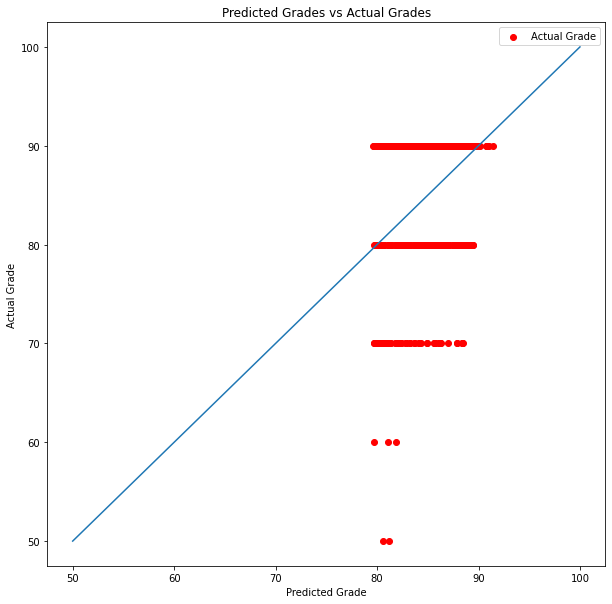

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(testing_features['predicted_grade'], testing_features['grade_num'], color="red", label = 'Actual Grade')
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
plt.title('Predicted Grades vs Actual Grades')

plt.legend()

plt.plot ([50,100],[50,100])

plt.show()

We see that the model is a lot less accurate this time. This is due to the fact that the data we used to train our model is largely **missing not at random**(https://en.wikipedia.org/wiki/Missing_data#Missing_not_at_random), as students are more likely to submit a review with their grades if they have a higher grade. Therefore, our model model often overestimates, only making predictions around the 80-90 range.

We decide to make a plot of ratings vs grades for both the actual grades and the predicted grade to see they follow the same trend.

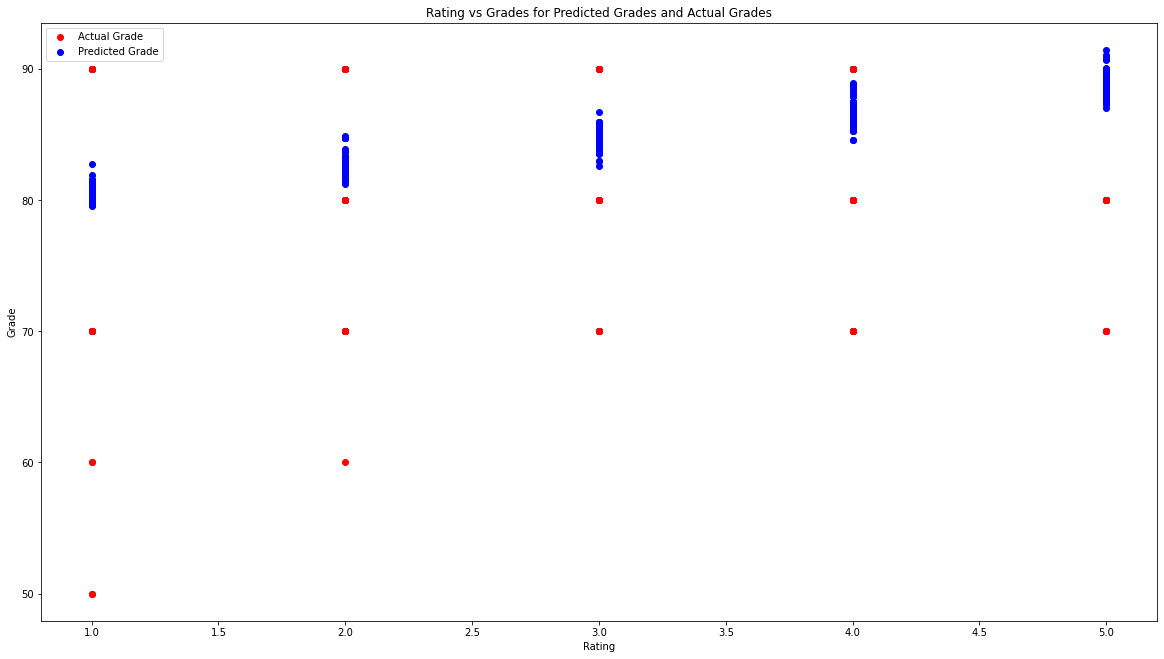

In [29]:
plt.figure(figsize=figsize)
plt.scatter(testing_features['rating'], testing_features['grade_num'], color="red", label = 'Actual Grade')
plt.scatter(testing_features['rating'], testing_features['predicted_grade'], color="blue", label = 'Predicted Grade')
plt.xlabel('Rating')
plt.ylabel('Grade')

plt.title('Rating vs Grades for Predicted Grades and Actual Grades')

plt.legend()

plt.show()

From the graph, we are able to see while the actual grades vary a lot more than our predicted grades, they do all follow the same trend of correlating positively with rating. 

With the trained model, we can try to predict the grades of reviews with missing expected grades.

In [30]:
predictions = []
missing_features = get_dummies(reviews_df)
X2 = missing_features.drop('grade_num', axis = 1)
y2 = missing_features['grade_num']

for i, row in X2.iterrows():
    predictions.append(round(reg2.predict([X2.loc[i]])[0],2))
        
reviews_df['predicted_grade'] = predictions

In [31]:
reviews_df[pd.isnull(reviews_df["grade_num"])]

,slug,rating,expected_grade,course,review,prof_df_id,grade_num,department,salary,predicted_grade
0,leitch,1,NaN,INST377,Professor is so rude and sarcastic. She is ver...,11,NaN,INFO,82416.00,83.24
3,leitch,1,NaN,INST377,This course was very disorganized. The workloa...,11,NaN,INFO,82416.00,83.24
10,heidenblad,2,NaN,INST346,Get ready to learn absolutely nothing. He desi...,26,NaN,INFO,82668.23,85.19
16,oard,4,NaN,INST154,The 3 major grades are 2 papers and one group ...,27,NaN,CMNS,42244.90,86.46
21,hassan_naeemul,3,NaN,JOUR152,Prof. Hassan is ok. He does his best to make t...,36,NaN,JOUR,55692.61,85.58
...,...,...,...,...,...,...,...,...,...,...
5254,tripp,1,NaN,FMSC487,She is rude and stuck up. Just like the previo...,2074,NaN,SPHL,13624.84,81.00
5255,tripp,1,NaN,FMSC487,The professor claims to be professional and op...,2074,NaN,SPHL,13624.84,81.00
5256,tripp,3,NaN,FMSC382,Professor Tripp is extremely disorganized. Eve...,2074,NaN,SPHL,13624.84,84.90
5283,desmond,5,NaN,HLTH391,Dr. Desmond is an amazing professor who really...,2109,NaN,SPHL,105317.82,88.29


From this model, it is very clear that when using data that are missing not at random to train a model, we will get rather biased results.

## Conclusion

With this tutorial, we analyzed the salary and review data for each of the professors in UMD. From the data analysis and visualizations we created, we discovered that the salary correlates negatively with a professor's rating and positively with the number of different courses a professor has taught. We are also able to see that the department a professor is in plays a role in the expected salary of a professor and the expected amount of different classes a professor has to teach. With these new insights, we created two models that can predict the salary of a professor based on the professor's rating, department, and the number of courses the professor teaches, as well as predict the grade of a student in a class based on the rating the student left, the salary of the professor and the department of the course. Through the second model, we also demonstrated the inaccuracies that could be caused by data that is missing not at random.